<a href="https://colab.research.google.com/github/xvzeng/Data-Science-for-Geochemistry/blob/main/Diamond_WithUnknown_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, r2_score, make_scorer, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import matplotlib as mpl
import lightgbm as lgb
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelBinarizer, LabelEncoder

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [13]:
from google.colab import files
uploaded = files.upload()

Saving 2020Diamind_XZ_1210.csv to 2020Diamind_XZ_1210 (1).csv


In [14]:
import io
diamond = pd.read_csv(io.BytesIO(uploaded['2020Diamind_XZ_1210.csv']))

In [15]:
diamond.columns

Index(['Unnamed: 0', 'craton', 'Si', 'Ti', 'Al', 'Cr', 'V', 'Mn', 'Mg', 'Ca',
       'Sr', 'Ba', 'Na', 'P', 'K', 'Fe', 'Co', 'Ni', 'S', 'Zn', 'Cr_trace',
       'Co_trace', 'Ni_trace', 'Sr_trace', 'Y_trace', 'Zr_trace', 'Nb_trace',
       'Ba_trace', 'La_trace', 'Ce_trace', 'Nd_trace', 'Sm_trace', 'Eu_trace',
       'Dy_trace', 'Er_trace', 'Yb_trace', 'Ti_trace', 'Fe_trace', 'Al_trace',
       'Ca_trace', 'Mn_trace', 'Mg_trace', 'NAs'],
      dtype='object')

In [16]:
df = diamond.copy()

In [17]:
df.drop(df.columns[df.isna().mean() == 1], axis=1, inplace=True)  # Remove columns that 100% missing 
df.shape

(1264, 43)

In [18]:
df.groupby('craton').describe()

Unnamed: 0                                                    \
                 count         mean         std     min      25%     50%   
craton                                                                     
Africa             3.0  1263.000000    1.000000  1262.0  1262.50  1263.0   
Amazonia          59.0   335.474576  142.549006   213.0   272.50   287.0   
Congo            128.0   415.601562  222.746293    46.0   332.75   389.5   
Guyana            60.0   399.866667  425.002033     1.0    15.75   433.5   
Kaapvaal         164.0   270.664634  216.191101    35.0    83.75   233.5   
Kalahari           4.0   531.500000    1.290994   530.0   530.75   531.5   
Siberia          580.0   882.484483  208.206640   348.0   757.75   902.5   
Slave            160.0   746.393750  344.645476    27.0   520.75   631.5   
Unknown           18.0   391.666667  352.413694    34.0   205.25   209.5   
West Africa       88.0   157.727273   25.854912   114.0   135.75   157.5   

                                 Si                                          \
                 75%     max  count       mean        std     min       25%   
craton                                                                        
Africa       1263.50  1264.0    0.0        NaN        NaN     NaN       NaN   
Amazonia      301.50   647.0   57.0   7.687175   9.625399   0.000   0.00900   
Congo         421.25  1251.0   44.0  22.520909   3.486496  18.719  19.28600   
Guyana        538.25  1216.0   58.0   8.217000  10.737342   0.000   0.01400   
Kaapvaal      577.25   653.0  163.0   8.348896   9.883350   0.000   0.00000   
Kalahari      532.25   533.0    1.0  19.508000        NaN  19.508  19.50800   
Siberia      1047.25  1261.0  533.0  18.987752   2.473030   1.167  19.16800   
Slave        1197.25  1258.0  148.0  10.802020  11.148504   0.000   0.00675   
Unknown       562.75  1253.0   17.0  15.203471  10.384094   0.000   0.00000   
West Africa   179.25   202.0   88.0  10.202045  11.401890   0.000   0.00000   

                                          Ti                              \
                 50%      75%     max  count      mean        std    min   
craton                                                                     
Africa           NaN      NaN     NaN    0.0       NaN        NaN    NaN   
Amazonia      0.0330  19.2970  24.971   57.0  8.479158  13.282617  0.005   
Congo        20.4370  26.1820  27.489   44.0  0.065545   0.159669  0.000   
Guyana        0.0280  19.2690  26.834   58.0  6.997121  12.774200  0.000   
Kaapvaal      0.0000  19.2570  25.849  163.0  0.090865   0.183972  0.000   
Kalahari     19.5080  19.5080  19.508    1.0  0.024000        NaN  0.024   
Siberia      19.2650  19.3650  44.194  533.0  0.020705   0.119510  0.000   
Slave         3.7335  19.9630  46.437  148.0  0.709784   1.408527  0.000   
Unknown      19.3620  22.2970  26.899   17.0  0.251765   0.375328  0.000   
West Africa   0.0745  19.4155  46.490   88.0  0.443898   3.437630  0.000   

                                                Al                             \
               25%    50%       75%     max  count      mean       std    min   
craton                                                                          
Africa         NaN    NaN       NaN     NaN    0.0       NaN       NaN    NaN   
Amazonia     0.014  0.078  17.24500  33.690   57.0  3.233211  4.864852  0.008   
Congo        0.005  0.006   0.04800   1.007   44.0  4.544250  5.265510  0.011   
Guyana       0.012  0.036   5.05475  33.656   58.0  1.972000  3.553148  0.000   
Kaapvaal     0.000  0.000   0.13800   1.319  163.0  4.081178  5.092419  0.000   
Kalahari     0.024  0.024   0.02400   0.024    1.0  8.894000       NaN  8.894   
Siberia      0.000  0.001   0.00200   1.379  533.0  0.459060  3.140587  0.000   
Slave        0.000  0.000   0.14400   5.874  148.0  3.123041  5.811462  0.000   
Unknown      0.000  0.018   0.48600   1.079   17.0  2.359882  2.502326  0.000   
West Africa  0.000  0.000   0.0000

In [19]:
df.head()

,Unnamed: 0,craton,Si,Ti,Al,Cr,V,Mn,Mg,Ca,Sr,Ba,Na,P,K,Fe,Co,Ni,S,Zn,Cr_trace,Co_trace,Ni_trace,Sr_trace,Y_trace,Zr_trace,Nb_trace,Ba_trace,La_trace,Ce_trace,Nd_trace,Sm_trace,Eu_trace,Dy_trace,Er_trace,Yb_trace,Ti_trace,Fe_trace,Al_trace,Ca_trace,Mn_trace,Mg_trace,NAs
0,1,Guyana,0.000,30.354,0.008,0.027,0.0,0.364,0.270,0.017,0.0,0.0,0.024,0.0,0.027,37.022,0.0,0.038,0.0,0.0,260.0,56.0,181.0,0.2,0.300,27.4,335.0,4.00,0.600,2.100,0.60,0.192,0.076,0.147,0.224,0.100,NaN,NaN,NaN,55.640,3251.0,NaN,48
1,2,Guyana,0.014,32.008,0.048,0.027,0.0,0.395,0.342,0.029,0.0,0.0,0.024,0.0,0.033,33.281,0.0,0.094,0.0,0.0,4172.0,429.0,6375.0,0.4,0.800,56.6,227.0,3.20,0.700,2.400,2.50,0.312,0.111,0.129,0.392,0.328,NaN,NaN,NaN,97.424,1887.0,NaN,48
2,3,Guyana,0.070,0.689,1.138,2.155,0.0,0.201,29.868,0.017,0.0,0.0,0.024,0.0,0.027,36.369,0.0,0.809,0.0,0.0,2944.0,155.0,790.0,1.6,0.144,25.2,4.8,0.56,0.096,0.056,0.32,0.400,0.160,0.320,0.640,0.320,NaN,NaN,NaN,156.800,2397.0,NaN,48
3,4,Guyana,0.005,30.102,0.008,0.027,0.0,0.565,0.072,0.021,0.0,0.0,0.024,0.0,0.027,35.941,0.0,0.038,0.0,0.0,153.0,53.0,13.0,0.2,0.300,348.7,646.0,2.30,0.500,1.900,0.70,0.300,0.069,0.186,0.248,0.154,NaN,NaN,NaN,71.488,2898.0,NaN,48
4,5,Guyana,0.028,32.464,0.069,0.027,0.0,0.325,0.300,0.017,0.0,0.0,0.024,0.0,0.027,31.290,0.0,0.055,0.0,0.0,NaN,NaN,NaN,0.3,0.500,68.7,205.0,8.80,0.800,2.900,0.70,0.100,0.000,0.100,0.256,0.500,NaN,NaN,NaN,67.304,NaN,NaN,53


In [20]:
df.isna().sum().sum()

20495

In [21]:
df=df.drop(df.columns[0], axis=1)

In [22]:
df=df.drop('NAs', axis=1)

In [23]:
df.head()

,craton,Si,Ti,Al,Cr,V,Mn,Mg,Ca,Sr,Ba,Na,P,K,Fe,Co,Ni,S,Zn,Cr_trace,Co_trace,Ni_trace,Sr_trace,Y_trace,Zr_trace,Nb_trace,Ba_trace,La_trace,Ce_trace,Nd_trace,Sm_trace,Eu_trace,Dy_trace,Er_trace,Yb_trace,Ti_trace,Fe_trace,Al_trace,Ca_trace,Mn_trace,Mg_trace
0,Guyana,0.000,30.354,0.008,0.027,0.0,0.364,0.270,0.017,0.0,0.0,0.024,0.0,0.027,37.022,0.0,0.038,0.0,0.0,260.0,56.0,181.0,0.2,0.300,27.4,335.0,4.00,0.600,2.100,0.60,0.192,0.076,0.147,0.224,0.100,NaN,NaN,NaN,55.640,3251.0,NaN
1,Guyana,0.014,32.008,0.048,0.027,0.0,0.395,0.342,0.029,0.0,0.0,0.024,0.0,0.033,33.281,0.0,0.094,0.0,0.0,4172.0,429.0,6375.0,0.4,0.800,56.6,227.0,3.20,0.700,2.400,2.50,0.312,0.111,0.129,0.392,0.328,NaN,NaN,NaN,97.424,1887.0,NaN
2,Guyana,0.070,0.689,1.138,2.155,0.0,0.201,29.868,0.017,0.0,0.0,0.024,0.0,0.027,36.369,0.0,0.809,0.0,0.0,2944.0,155.0,790.0,1.6,0.144,25.2,4.8,0.56,0.096,0.056,0.32,0.400,0.160,0.320,0.640,0.320,NaN,NaN,NaN,156.800,2397.0,NaN
3,Guyana,0.005,30.102,0.008,0.027,0.0,0.565,0.072,0.021,0.0,0.0,0.024,0.0,0.027,35.941,0.0,0.038,0.0,0.0,153.0,53.0,13.0,0.2,0.300,348.7,646.0,2.30,0.500,1.900,0.70,0.300,0.069,0.186,0.248,0.154,NaN,NaN,NaN,71.488,2898.0,NaN
4,Guyana,0.028,32.464,0.069,0.027,0.0,0.325,0.300,0.017,0.0,0.0,0.024,0.0,0.027,31.290,0.0,0.055,0.0,0.0,NaN,NaN,NaN,0.3,0.500,68.7,205.0,8.80,0.800,2.900,0.70,0.100,0.000,0.100,0.256,0.500,NaN,NaN,NaN,67.304,NaN,NaN


In [24]:
df.craton.value_counts()

Siberia        580
Kaapvaal       164
Slave          160
Congo          128
West Africa     88
Guyana          60
Amazonia        59
Unknown         18
Kalahari         4
Africa           3
Name: craton, dtype: int64

In [25]:
df.craton.nunique()

10

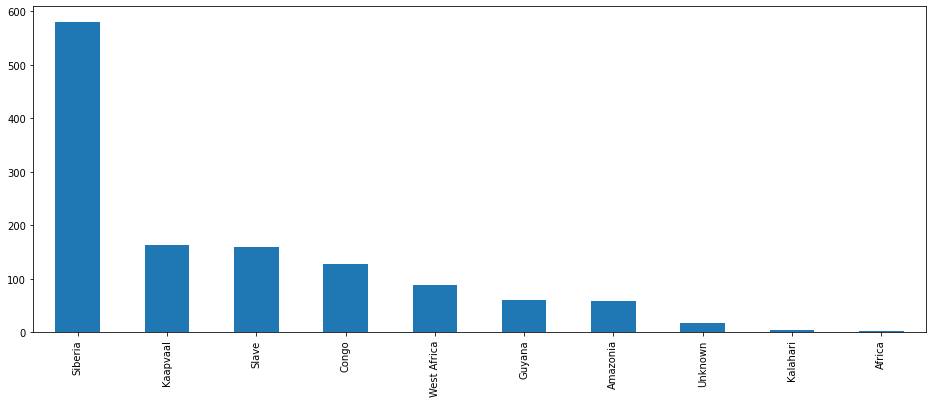

In [26]:
plt.figure(figsize=(16, 6))
df.craton.value_counts().plot(kind = 'bar')

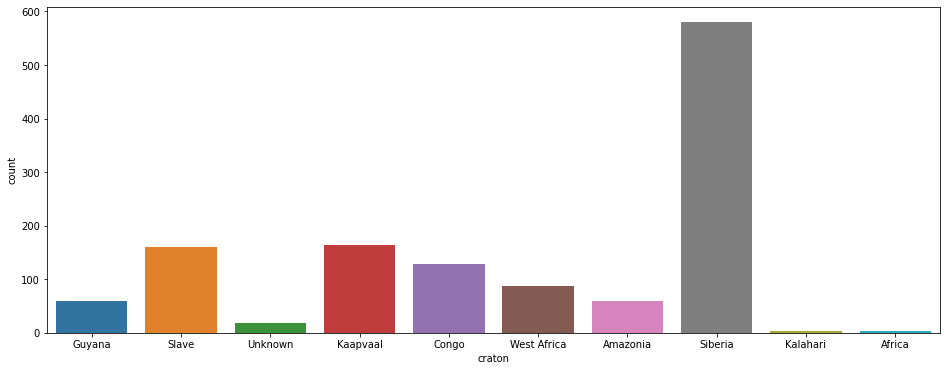

In [27]:
plt.figure(figsize=(16, 6))
sns.countplot(df.craton)

In [28]:
df.craton=df.craton.astype('category')

In [29]:
df.craton.nunique()
df.craton.value_counts()

Siberia        580
Kaapvaal       164
Slave          160
Congo          128
West Africa     88
Guyana          60
Amazonia        59
Unknown         18
Kalahari         4
Africa           3
Name: craton, dtype: int64

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264 entries, 0 to 1263
Data columns (total 41 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   craton    1264 non-null   category
 1   Si        1109 non-null   float64 
 2   Ti        1109 non-null   float64 
 3   Al        1109 non-null   float64 
 4   Cr        1109 non-null   float64 
 5   V         955 non-null    float64 
 6   Mn        1102 non-null   float64 
 7   Mg        1109 non-null   float64 
 8   Ca        1109 non-null   float64 
 9   Sr        940 non-null    float64 
 10  Ba        947 non-null    float64 
 11  Na        1102 non-null   float64 
 12  P         1018 non-null   float64 
 13  K         1108 non-null   float64 
 14  Fe        1109 non-null   float64 
 15  Co        945 non-null    float64 
 16  Ni        1075 non-null   float64 
 17  S         950 non-null    float64 
 18  Zn        945 non-null    float64 
 19  Cr_trace  686 non-null    float64 
 20  Co_trace

Split data into craton and elements

In [31]:
cratons = df.craton.values
cratons=cratons.astype('str')
cratons

array(['Guyana', 'Guyana', 'Guyana', ..., 'Africa', 'Africa', 'Africa'],
      dtype='<U11')

In [32]:
le = LabelEncoder()
cratons = le.fit_transform(cratons)
cratons

array([3, 3, 3, ..., 0, 0, 0])

In [33]:
features = df.drop(['craton'], axis=1)
features.shape

(1264, 40)

In [34]:
features.head()
features.columns

Index(['Si', 'Ti', 'Al', 'Cr', 'V', 'Mn', 'Mg', 'Ca', 'Sr', 'Ba', 'Na', 'P',
       'K', 'Fe', 'Co', 'Ni', 'S', 'Zn', 'Cr_trace', 'Co_trace', 'Ni_trace',
       'Sr_trace', 'Y_trace', 'Zr_trace', 'Nb_trace', 'Ba_trace', 'La_trace',
       'Ce_trace', 'Nd_trace', 'Sm_trace', 'Eu_trace', 'Dy_trace', 'Er_trace',
       'Yb_trace', 'Ti_trace', 'Fe_trace', 'Al_trace', 'Ca_trace', 'Mn_trace',
       'Mg_trace'],
      dtype='object')

In [35]:
def plot_importance(feature_df, model, n_feature):
    '''
    Input:
        feature_df: The feature dataframe / The X_train with column names
        model: The training model
        n_feature: number of feature importance you want to display
    Output:
        A plot with the top n feature importance in decreasing order
    '''
    vals = model.feature_importances_
    df = pd.DataFrame(vals, index=feature_df.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
    df_n = df.iloc[:n_feature,]
    plt.figure(figsize=(16, 9))
    plt.bar(df_n.index, df_n.Importance)
    plt.xticks(rotation=90)

In [36]:
def print_results(y_true, y_pred, dataset):
    print(dataset,'-- R2: {0}, Accuracy Score: {1}'.format(r2_score(y_true, y_pred), 
                                                              accuracy_score(y_true, y_pred)))

Split into training set and test set

In [37]:
X_train, X_test, y_train, y_test = train_test_split(features, cratons, test_size=0.2, 
                                                    stratify = cratons, random_state = 2020)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1011, 40), (253, 40), (1011,), (253,))

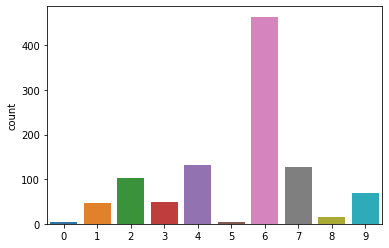

In [38]:
sns.countplot(y_train)

In [39]:
gbm = lgb.LGBMClassifier(objective='multiclass')
gbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [40]:
preds = gbm.predict(X_train)
probs = gbm.predict_proba(X_train)

In [41]:
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score, roc_curve
print('Recall: ', recall_score(y_train, preds, average='weighted'))
print('Precision: ', precision_score(y_train, preds, average='weighted'))
print('ROC AUC: ', roc_auc_score(y_train, probs, multi_class='ovo'))

Recall:  1.0
Precision:  1.0
ROC AUC:  1.0


In [42]:
gbm.fit(X_test, y_test)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [43]:
len(X_test)

253

In [44]:
len(y_test)

253

In [45]:
preds = gbm.predict(X_test)
probs = gbm.predict_proba(X_test)

In [46]:
len(probs)

253

In [48]:
print('Recall: ', recall_score(y_test, preds, average='weighted'))
print('Precision: ', precision_score(y_test, preds, average='weighted'))
print('ROC AUC: ', roc_auc_score(y_test, probs, multi_class='ovo'))

Recall:  1.0
Precision:  1.0
ROC AUC:  1.0


In [49]:
importances = gbm.feature_importances_
indices = np.argsort(importances)

In [50]:
impo=pd.DataFrame({'element':df.drop(['craton'], axis=1).columns, 'importance':importances})

In [51]:
impo=impo.sort_values(by=['importance'], ascending=False)
impo

,element,importance
19,Co_trace,604
34,Ti_trace,578
20,Ni_trace,456
0,Si,437
18,Cr_trace,423
6,Mg,409
1,Ti,322
3,Cr,315
5,Mn,305
15,Ni,283


[Text(0, 0, 'Co_trace'),
 Text(0, 0, 'Ti_trace'),
 Text(0, 0, 'Ni_trace'),
 Text(0, 0, 'Si'),
 Text(0, 0, 'Cr_trace'),
 Text(0, 0, 'Mg'),
 Text(0, 0, 'Ti'),
 Text(0, 0, 'Cr'),
 Text(0, 0, 'Mn'),
 Text(0, 0, 'Ni'),
 Text(0, 0, 'Al_trace'),
 Text(0, 0, 'Mg_trace'),
 Text(0, 0, 'Ca_trace'),
 Text(0, 0, 'Fe'),
 Text(0, 0, 'Co'),
 Text(0, 0, 'Al'),
 Text(0, 0, 'Mn_trace'),
 Text(0, 0, 'Ca'),
 Text(0, 0, 'Ba_trace'),
 Text(0, 0, 'La_trace'),
 Text(0, 0, 'Fe_trace'),
 Text(0, 0, 'K'),
 Text(0, 0, 'Sr_trace'),
 Text(0, 0, 'Eu_trace'),
 Text(0, 0, 'Ce_trace'),
 Text(0, 0, 'Sm_trace'),
 Text(0, 0, 'Nb_trace'),
 Text(0, 0, 'P'),
 Text(0, 0, 'Na'),
 Text(0, 0, 'Yb_trace'),
 Text(0, 0, 'Y_trace'),
 Text(0, 0, 'Dy_trace'),
 Text(0, 0, 'Zr_trace'),
 Text(0, 0, 'Nd_trace'),
 Text(0, 0, 'V'),
 Text(0, 0, 'Er_trace'),
 Text(0, 0, 'Ba'),
 Text(0, 0, 'Sr'),
 Text(0, 0, 'Zn'),
 Text(0, 0, 'S')]

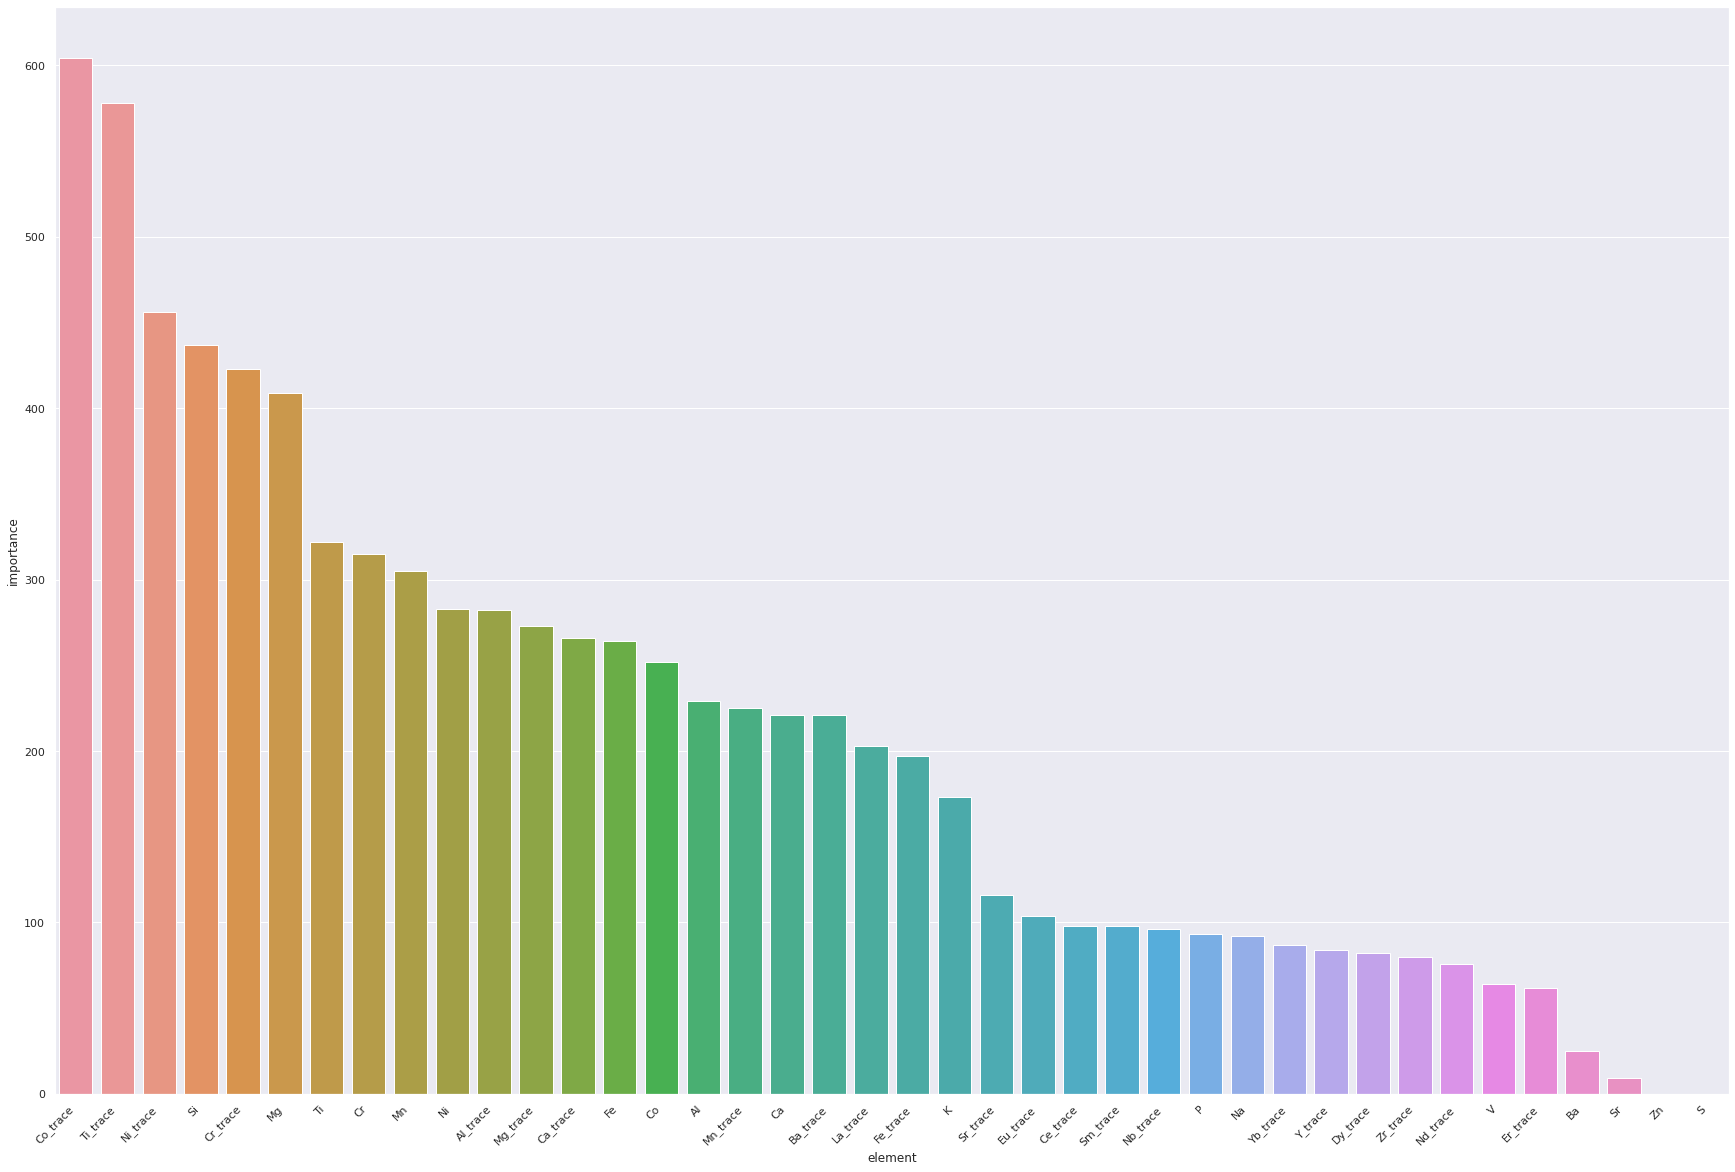

In [52]:
sns.set(rc={'figure.figsize':(30,20)})
FI=sns.barplot(y=impo.importance, x=impo.element)
FI.set_xticklabels(FI.get_xticklabels(), rotation=45, horizontalalignment='right')

In [53]:
gbm2 = lgb.LGBMClassifier(objective='multiclass',num_leaves=31,learning_rate=0.05,n_estimators=20)
gbm2.fit(X_train, y_train,eval_set=[(X_test, y_test)],early_stopping_rounds=5)

[1]	valid_0's multi_logloss: 1.54671
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's multi_logloss: 1.43906
[3]	valid_0's multi_logloss: 1.35052
[4]	valid_0's multi_logloss: 1.27165
[5]	valid_0's multi_logloss: 1.20225
[6]	valid_0's multi_logloss: 1.13954
[7]	valid_0's multi_logloss: 1.08087
[8]	valid_0's multi_logloss: 1.02812
[9]	valid_0's multi_logloss: 0.977981
[10]	valid_0's multi_logloss: 0.931076
[11]	valid_0's multi_logloss: 0.889201
[12]	valid_0's multi_logloss: 0.849303
[13]	valid_0's multi_logloss: 0.812867
[14]	valid_0's multi_logloss: 0.779125
[15]	valid_0's multi_logloss: 0.746806
[16]	valid_0's multi_logloss: 0.716833
[17]	valid_0's multi_logloss: 0.687912
[18]	valid_0's multi_logloss: 0.66082
[19]	valid_0's multi_logloss: 0.63576
[20]	valid_0's multi_logloss: 0.612579
Did not meet early stopping. Best iteration is:
[20]	valid_0's multi_logloss: 0.612579


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=20, n_jobs=-1, num_leaves=31,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [54]:
y_pred = gbm2.predict(X_test, num_iteration=gbm.best_iteration_)

In [55]:
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 0.9409439377939295


In [56]:
print('Feature importances:', list(gbm2.feature_importances_))

Feature importances: [267, 56, 90, 246, 43, 164, 197, 160, 1, 22, 116, 117, 180, 270, 35, 281, 50, 0, 212, 253, 201, 171, 53, 258, 233, 195, 142, 66, 62, 34, 50, 41, 41, 72, 441, 251, 35, 396, 120, 178]


In [57]:
importances = gbm2.feature_importances_
indices = np.argsort(importances)

In [58]:
len(importances)

40

In [59]:
impo2=pd.DataFrame({'element':df.drop(['craton'], axis=1).columns, 'importance':importances})

In [60]:
impo2=impo2.sort_values(by=['importance'], ascending=False)
impo2

,element,importance
34,Ti_trace,441
37,Ca_trace,396
15,Ni,281
13,Fe,270
0,Si,267
23,Zr_trace,258
19,Co_trace,253
35,Fe_trace,251
3,Cr,246
24,Nb_trace,233


[Text(0, 0, 'Ti_trace'),
 Text(0, 0, 'Ca_trace'),
 Text(0, 0, 'Ni'),
 Text(0, 0, 'Fe'),
 Text(0, 0, 'Si'),
 Text(0, 0, 'Zr_trace'),
 Text(0, 0, 'Co_trace'),
 Text(0, 0, 'Fe_trace'),
 Text(0, 0, 'Cr'),
 Text(0, 0, 'Nb_trace'),
 Text(0, 0, 'Cr_trace'),
 Text(0, 0, 'Ni_trace'),
 Text(0, 0, 'Mg'),
 Text(0, 0, 'Ba_trace'),
 Text(0, 0, 'K'),
 Text(0, 0, 'Mg_trace'),
 Text(0, 0, 'Sr_trace'),
 Text(0, 0, 'Mn'),
 Text(0, 0, 'Ca'),
 Text(0, 0, 'La_trace'),
 Text(0, 0, 'Mn_trace'),
 Text(0, 0, 'P'),
 Text(0, 0, 'Na'),
 Text(0, 0, 'Al'),
 Text(0, 0, 'Yb_trace'),
 Text(0, 0, 'Ce_trace'),
 Text(0, 0, 'Nd_trace'),
 Text(0, 0, 'Ti'),
 Text(0, 0, 'Y_trace'),
 Text(0, 0, 'Eu_trace'),
 Text(0, 0, 'S'),
 Text(0, 0, 'V'),
 Text(0, 0, 'Dy_trace'),
 Text(0, 0, 'Er_trace'),
 Text(0, 0, 'Co'),
 Text(0, 0, 'Al_trace'),
 Text(0, 0, 'Sm_trace'),
 Text(0, 0, 'Ba'),
 Text(0, 0, 'Sr'),
 Text(0, 0, 'Zn')]

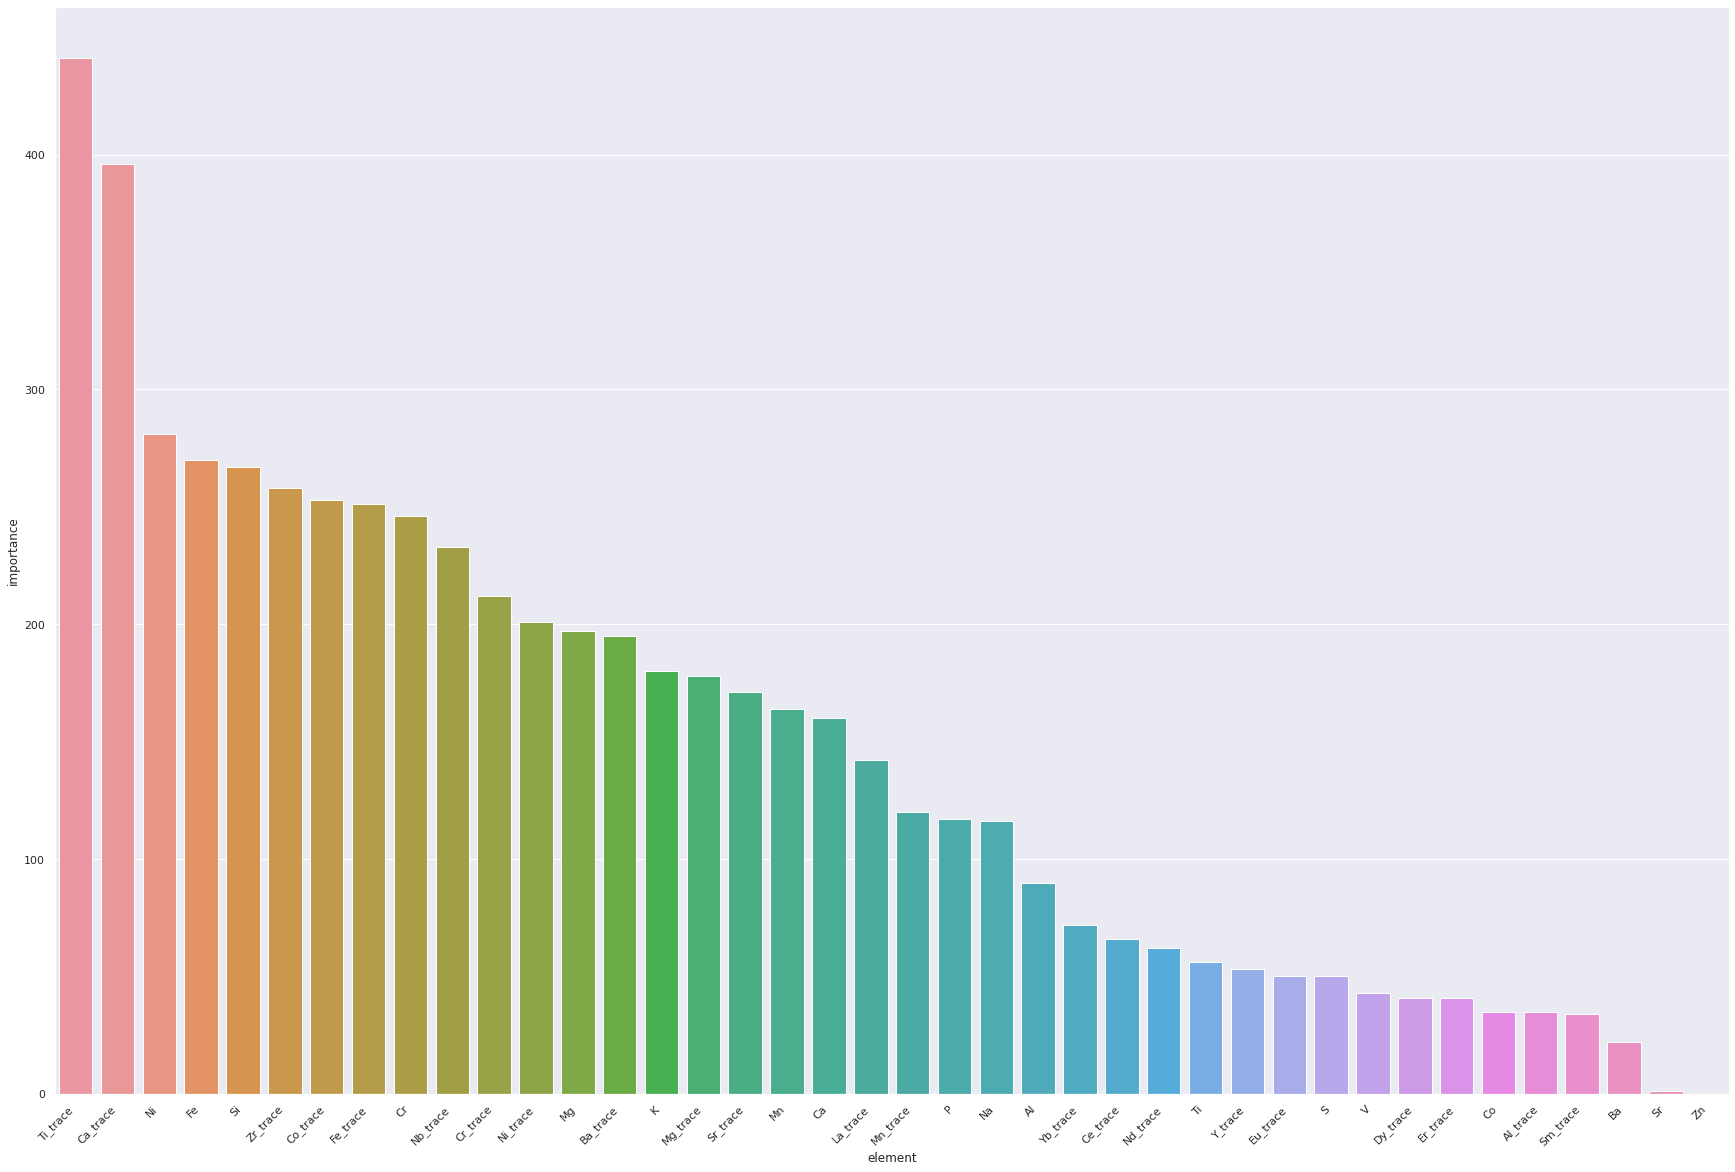

In [61]:
sns.set(rc={'figure.figsize':(30,20)})
FI=sns.barplot(y=impo2.importance, x=impo2.element)
FI.set_xticklabels(FI.get_xticklabels(), rotation=45, horizontalalignment='right')

In [62]:
ImportanceCompare = pd.concat([impo, impo2], axis=1)
ImportanceCompare

,element,importance,element,importance
0,Si,437,Si,267
1,Ti,322,Ti,56
2,Al,229,Al,90
3,Cr,315,Cr,246
4,V,64,V,43
5,Mn,305,Mn,164
6,Mg,409,Mg,197
7,Ca,221,Ca,160
8,Sr,9,Sr,1
9,Ba,25,Ba,22


In [63]:
gbm_cv = lgb.LGBMClassifier(objective='multiclass', random_state=2020)
gbm_cv.fit(X_train, y_train)
y_train_preds = gbm_cv.predict(X_train)
y_test_preds = gbm_cv.predict(X_test)
#gbm_cv= lgb.LGBMClassifier(objective='multiclass',num_leaves=31,learning_rate=0.05,n_estimators=20)
#gbm2.fit(X_train, y_train,eval_set=[(X_test, y_test)],early_stopping_rounds=5)
lgb.LGBMClassifier()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [64]:
print_results(y_train, y_train_preds, 'training')

training -- R2: 1.0, Accuracy Score: 1.0


In [65]:
print_results(y_test, y_test_preds, 'test')

test -- R2: 0.9846442146471736, Accuracy Score: 0.9802371541501976


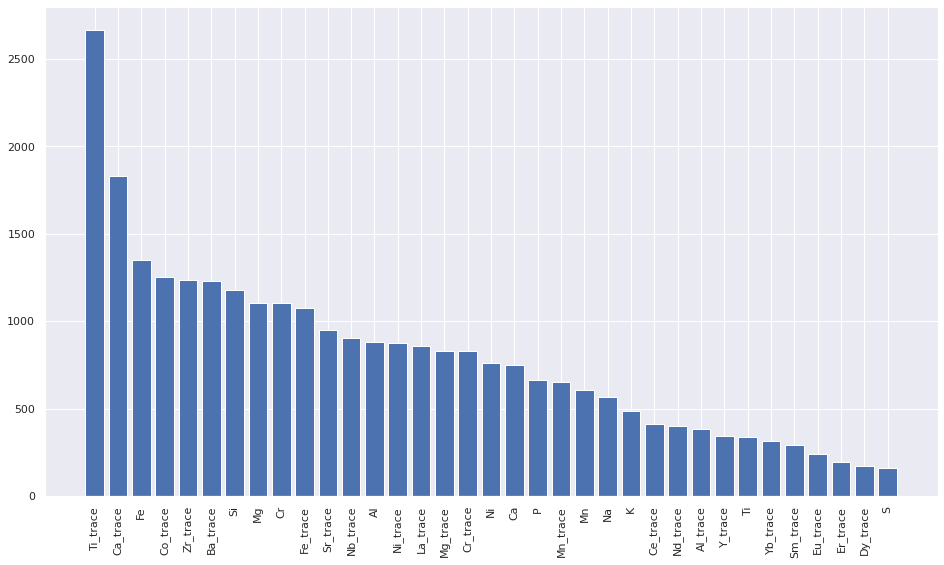

In [66]:
plot_importance(features, gbm_cv, 35)

In [67]:
learning_rate = [0.01, 0.05, 0.1, 0.2, 1]
depth = [3, 4, 5, 6, 7]
min_split = [1, 2, 3, 4, 5]

In [68]:
lgb = lgb.LGBMClassifier(objective='multiclass', num_class = 10, eval_metric = 'merror', tree_method='hist', seed=2020)

In [69]:
lgb_cv = GridSearchCV(lgb, param_grid = {'eta': learning_rate, 'gamma': min_split, 'max_depth': depth}, 
                      cv=5, scoring='accuracy')
lgb_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      eval_metric='merror',
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_class=10, num_leaves=31,
                                      objective='multiclass', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0, seed=2020,
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                                      subsample_freq=0, tree_met

In [70]:
lgb_cv.best_params_

{'eta': 0.01, 'gamma': 1, 'max_depth': 4}

In [71]:
lgb_cv.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               eta=0.01, eval_metric='merror', gamma=1, importance_type='split',
               learning_rate=0.1, max_depth=4, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_class=10, num_leaves=31, objective='multiclass',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=2020,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0, tree_method='hist')

In [72]:
lgb_cv.best_score_

0.9485685021704141

In [73]:
lgb_best = lgb_cv.best_estimator_

In [74]:
y_train_preds = lgb_best.predict(X_train)
y_test_preds = lgb_best.predict(X_test)

In [75]:
print_results(y_train, y_train_preds, 'training')

training -- R2: 1.0, Accuracy Score: 1.0


In [76]:
print_results(y_test, y_test_preds, 'test')

test -- R2: 0.950093697603314, Accuracy Score: 0.9762845849802372


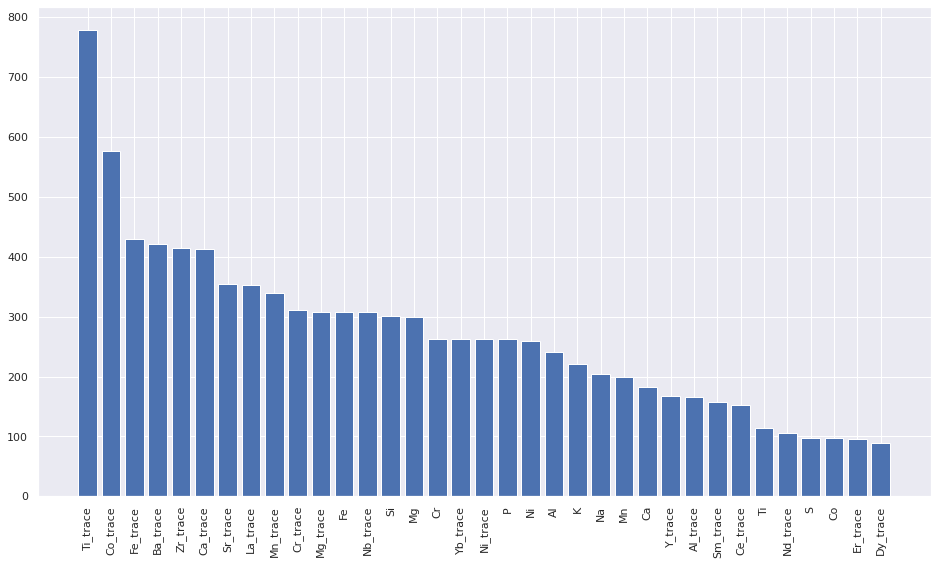

In [77]:
plot_importance(features, lgb_best, 35)

In [85]:
lgb_best = lgb.LGBMClassifier(objective='multiclass', num_class = 10, 
                          eval_metric = 'merror', tree_method='hist', 
                          eta = 0.01, gamma = 1, max_depth = 4, seed=2020)
lgb_best.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               eta=0.01, eval_metric='merror', gamma=1, importance_type='split',
               learning_rate=0.1, max_depth=4, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_class=10, num_leaves=31, objective='multiclass',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=2020,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0, tree_method='hist')

In [86]:
y_train_preds = lgb_best.predict(X_train)
y_test_preds = lgb_best.predict(X_test)

In [87]:
print_results(y_train, y_train_preds, 'training')

training -- R2: 1.0, Accuracy Score: 1.0


In [88]:
print_results(y_test, y_test_preds, 'test')

test -- R2: 0.950093697603314, Accuracy Score: 0.9762845849802372


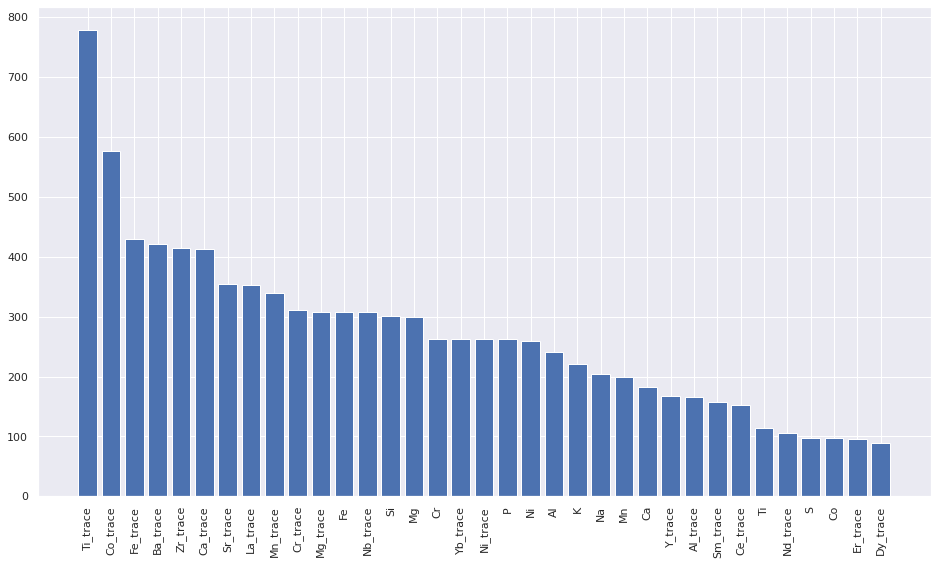

In [89]:
plot_importance(features, lgb_best, 35)

In [93]:
pip install shap

     |████████████████████████████████| 327kB 9.3MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463900 sha256=dac221bf070b214d13ca1d8df930be4df0693505b546e297992d2751dc14a11a
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [94]:
import shap

In [95]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(lgb_best)
shap_values = explainer.shap_values(X_train)

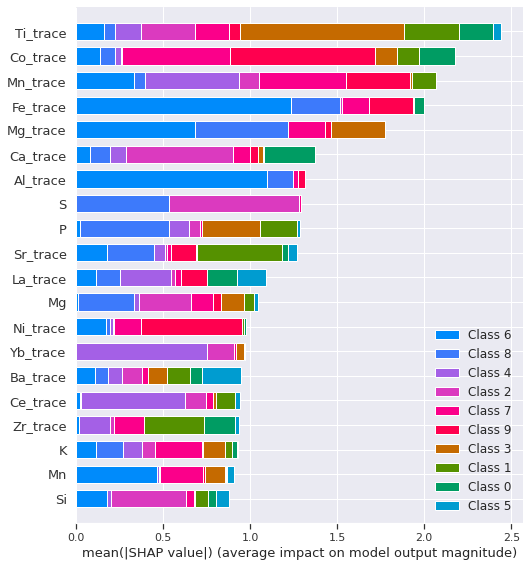

In [96]:
# take the mean absolute value of the SHAP values for 
# each feature to get a standard bar plot (produces stacked bars for multi-class outputs)
shap.summary_plot(shap_values, X_train, plot_type="bar")